# Click prediction challenge solution

First let's import the most essential libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset

Now, let's import the data:

In [8]:
df = pd.read_csv('android_bids_us.csv')

In [9]:
df.head()

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0
2,7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0
3,b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0
4,fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0


Let's inspect the data in order to get sense of how much missing data we have, which features are present and what should be modified before applying next steps

In [10]:
df.shape

(3148828, 12)

There are over 3 millions samples, 11 features and 1 target variable. This should be enough for binary classification problem. However, the number of features might not be sufficient for training a powerful model. Thus, generating new features should be considered further. 

Verify that the column containing the target variable is valid:

In [40]:
df['click'].describe()

count    3.148828e+06
mean     6.770741e-02
std      2.512432e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: click, dtype: float64

The range of the values is between 0 and 1 inclusively.

In [41]:
df['click'].nunique()

2

There are only two values, combined with the max and min values we imply that they are 0 and 1

In [37]:
df['click'].isnull().sum()

0

And finally, there are no missing values.

Let's inspect how many positively labeled samples are in the data:

In [24]:
np.sum(df['click'])

213199

For further reuse, define a function that gets a dataframe containing 'click' column as an input and outputs the rate of positive labels in the given dataframe:

In [42]:
# count the rate of positive labels
def positive_labels_rate(df):
    return np.sum(df['click']) / df.shape[0]
positive_labels_rate(df)

0.06770741367899422

Only about 7% of the samples are labeled positively

Before we start modifying the dataset, let's put aside a holdout test set. This is important to preserve its natural essence - as it would arrive as unseen data. The number of samples allows us to holdout a bigger test set, we should only verify that the rate of positive labels remains:

In [31]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.35)
print(f'Train shape: {train_df.shape}, positive labels rate: {positive_labels_rate(train_df)}')
print(f'Test shape: {test_df.shape}, positive labels rate: {positive_labels_rate(test_df)}')

Train shape: (2046738, 12), positive labels rate: 0.06777125357520113
Test shape: (1102090, 12), positive labels rate: 0.0675888539048535


As we can see the samples were divided evenly.

Now, separate the target variable from the independent variables:

In [45]:
X_train_df, y_train_df = train_df.drop(['click'], axis=1), train_df['click']
X_test_df, y_test_df = test_df.drop(['click'], axis=1), test_df['click']

In [49]:
X_train_df.shape, y_train_df.shape

((2046738, 11), (2046738,))

# Clean the data

First, I am going to inspect the data from the train dataframe more thoroughly and based on that define a function that will clean the data and get rid of noise. Then this function can be reused when new data is passed. For sake of clarity, the modifications will be numbered (*) throughout the analysis and later be referred from the cleaning function.

Let's analyze the statistics:

In [130]:
X_train_df.describe()

,utc_time,device_height,device_width
count,2.046738e+06,2.046738e+06,2.046738e+06
mean,1.538332e+12,1.180618e+03,1.152108e+03
std,2.319730e+09,5.189612e+02,4.525558e+02
min,1.533578e+12,1.400000e+01,1.400000e+01
25%,1.536459e+12,7.200000e+02,7.200000e+02
50%,1.538470e+12,1.080000e+03,1.080000e+03
75%,1.540090e+12,1.280000e+03,1.280000e+03
max,1.542630e+12,3.120000e+03,3.120000e+03


Only 3 features are numerical

In [131]:
X_train_df.isnull().sum() # count missing entries

bidid                 0
utc_time              0
app_id                0
user_state            0
user_isp             23
device_maker     626877
device_model     626776
device_osv            0
device_height         0
device_width          0
marketplace           0
dtype: int64

device_maker and device_model both contain a significant number of missing values. Let's find the optimal way to handle this issue, whereas samples with missing user_isp can be discarded.

In [53]:
X_train_df[['user_isp', 'device_model', 'device_maker']].describe()

,user_isp,device_model,device_maker
count,2046715,1419962,1419861
unique,3171,2169,240
top,T-Mobile USA,LM-X210(G),Samsung
freq,479062,71791,561128


These are categorical variables. Note that device_model predefines device_maker. It suggests that device_maker feature is redundant, however, we will retain it for now. We will inspect the correlation of these variables during analysis of the features importance. 

### (1) 
Due to the fact, that missing values constitute a large part of the data I chose to replace NaN values with the most frequent element in the column and in addition to that, to create a new column with 1 if the corresponding category is NaN else 0. This column represents an importance column to the imputed category.

This solution is not optimal because it generates bias towards the most frequent values but at the same time we don't lose the samples and we encode the importance of these mock values by adding an additional column which mitigates the consequences.

In [54]:
X_train_df.nunique()

bidid            1957220
utc_time         2046173
app_id             13792
user_state            51
user_isp            3171
device_maker         240
device_model        2169
device_osv            19
device_height        282
device_width         235
marketplace            1
dtype: int64

In [56]:
X_train_df['user_state'].describe()

count     2046738
unique         51
top            TX
freq       265729
Name: user_state, dtype: object

In [ ]:
df = df.fillna(df.mode().iloc[0])


In [111]:
devices_count = X_train_df.groupby(['device_model', 'device_maker']).size().reset_index(name='count').sort_values(by='count', ascending=False)
devices_count.shape

(2181, 3)

In [116]:
devices_count['device'] = devices_count[['device_model', 'device_maker']].apply(lambda x: '_'.join(x), axis=1)
devices_count.drop(['device_model', 'device_maker'], axis=1, inplace=True)
devices_count.head()

,count,device
830,71787,LM-X210(G)_LG
1522,67711,SM-J327T1_Samsung
974,57364,Moto E4_Motorola
923,50711,MP260_LG
925,29809,MS210_LG


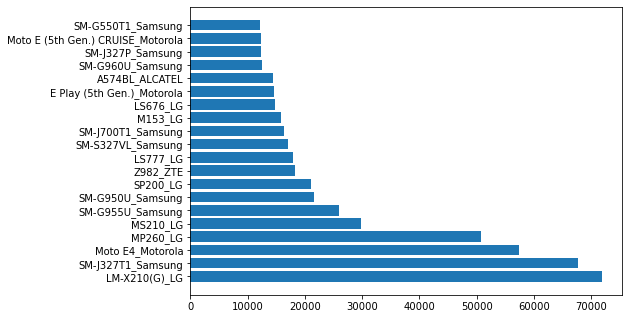

In [129]:
# plt.hist(devices_count['count'], log=True)
# # plt.xlabel(devices_count['device'])
# plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = devices_count['device'][:20]
students = devices_count['count'][:20]
ax.barh(langs, students)
plt.show()

In [82]:
device_freq[['device_model', 'device_maker']].agg('_'.join, axis=0)

Series([], Name: bidid, dtype: object)